<h1 style="color:orange;text-align:center;font-family:courier;font-size:280%">OCR Model using CNN+RNN+CTC</h1>
<p style="color:orange;text-align:center;font-family:courier"> The objective is to train and OCR(optical character recognition) model and understand how individual components like CNN,RNN and CTC loss works under the hood</p>

### Breaking the Training process
* Building a Convolution Neural Network as image feature extractor.
* Building a Recurrent Neural Network and CTC layer which consumes image features and transcripts into a trainable text reader. 
* Using CTC layer as CTC loss to the training objective.
* Since there is no one to one mapping between input and output, CTC solves the training objective by learning the best possible alignment. 
<!-- * Though the code works there are significant drawbacks with yolov1 which has been addressed on YoloV2,YoloV3 -->


<p style="text-align:center"><img src="assets/ocr.jpg" alt="ocr" width="840"/>

 

#### Tasks
* Import Dependency
* Setting up dataset path

In [1]:
import cv2
import numpy as np
from data_utils import *
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping,
                                        TensorBoard,
                                        ModelCheckpoint)

#Download the dataset from the repo README.md

root = "ocr_dataset/"
train_path = os.path.join(root,"train","*")
valid_path = os.path.join(root,"val","*")

### Parameters
* max_length  -  This determines the maximum length of characters the model can output, should be solely decided based on the problem and dataset.
* image dimensions  -  img_height or width should be chosen carefully based on landscape or portrait since image information can be distorted. Here we are using landscape images were width of the image is always higher.

In [2]:
batch_size = 16
max_length = 10
img_height,img_width = 44,164
epochs = 50

#### Organizing Dataset Pipeline
* prepare training set
* prepare validation set

#### Some Best Practices
* Keep Data Processing in CPU and Utilize GPU for training.
* Utilize prefetch and shuffle with respect to your Hardware configuration.

In [3]:
label_list,char2num,num2char = build_labels(label=build_from_data(root))
train_images,train_targets   = get_data(train_path,char2num,max_length=max_length)
valid_images,valid_targets   = get_data(valid_path,char2num,max_length=max_length)

train = tf.data.Dataset.from_tensor_slices((train_images,train_targets,[img_height]*len(train_images),[img_width]*len(train_images)))
train = train.map(process_file,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.batch(batch_size).shuffle(len(train_images)).prefetch(1).repeat()
valid = tf.data.Dataset.from_tensor_slices((valid_images,valid_targets,[img_height]*len(valid_images),[img_width]*len(valid_images)))
valid = valid.map(process_file,num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid = valid.batch(batch_size).prefetch(1)

#### Dataset structure explained and Visualization of inputs and outputs

<p style="text-align:center"><img src="assets/data.png" alt="ocr" width="1080"/>

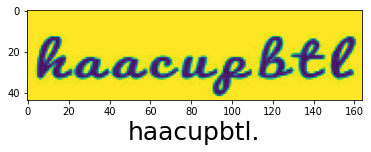

In [4]:
for x in train.take(1):
    random_sample = np.random.randint(0,batch_size,1)[0]
    inp_array = tf.transpose(x["image"][random_sample],perm=[1,0,2]).numpy()[:,:,0]
    inp_array *= 255.
    inp_array = np.uint8(inp_array)
    plt.imshow(inp_array)
    target_array = x["label"][random_sample]
    string = "".join([num2char[s] for s in target_array.numpy().tolist()])
    string = string.replace("'"," ")
    plt.xlabel(string,fontsize=25)

#### Connectionist Temporal Classification (CTC) loss overview:

* CTC loss is different from traditional loss functions like entropy, mse etc..
* We use CTC because it eliminates the need for alignment between input and output

<p style="text-align:center"><img src="assets/ctc.png" alt="ocr" width="1080"/></p>

#### Some In depth exploration and references to understand CTC loss:
* http://www.cs.toronto.edu/~graves/icml_2006.pdf
* https://distill.pub/2017/ctc/
* https://www.youtube.com/watch?v=A8IhGQCurPc

In [5]:
class Ctc_Layer(layers.Layer):
    def __init__(self,name=None):
        super(Ctc_Layer,self).__init__()
        
    def call(self,y_true,y_pred):
        """connectionist temporal classification is a loss function but 
        works little bit different from tradition loss, it is used as a
        layer and we utilize add_loss method of layer object to compute 
        loss directly while training"""
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length,label_length)
        self.add_loss(loss)
        return y_pred

### Model (CNN+RNN) Architecture
<p style="text-align:center"><img src="assets/arch.png" alt="arch" width="480"/></p>

### Our Architecture is very similar to above diagram but with few modifcations with:
* Number of layers.
* Convlution parameters.
* LSTM Parameters.

In [6]:
def conv_rnn_ctc(img_width,img_height,max_length):
    inp_image = layers.Input(shape=(img_width,img_height,1),name="image")
    inp_label = layers.Input(shape=(None,),name="label")
    
    x = layers.Conv2D(64,3,padding="same",activation='relu')(inp_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = layers.Conv2D(128,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = layers.Conv2D(128,3,padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    

    x = layers.Reshape(target_shape=(img_width//8,-1))(x)
    assert max_length*2<=x.shape[1]
    x = layers.Dense(128)(x)
    x = layers.LSTM(128,return_sequences=True, dropout=0.25)(x)
    x = layers.LSTM(64,return_sequences=True)(x)
    
    x = layers.Dense(len(label_list)+1,activation="softmax",name="output")(x)
     
    ctc_out = Ctc_Layer()(inp_label,x)

    build = Model(inputs=[inp_image,inp_label],outputs=[ctc_out],name="ocr_model")
    build.compile(optimizer=tf.keras.optimizers.Nadam(1e-3))
    return build 

#### Model Training

Epoch 1/50
288/288 [==============================] - 9s 18ms/step - loss: 32.3263 - val_loss: 43.9588
Epoch 2/50
288/288 [==============================] - 4s 12ms/step - loss: 16.8827 - val_loss: 5.2192
Epoch 3/50
288/288 [==============================] - 4s 13ms/step - loss: 1.3213 - val_loss: 3.4494
Epoch 4/50
288/288 [==============================] - 4s 13ms/step - loss: 0.5665 - val_loss: 7.0340
Epoch 5/50
288/288 [==============================] - 4s 12ms/step - loss: 0.3668 - val_loss: 1.0629
Epoch 6/50
288/288 [==============================] - 4s 12ms/step - loss: 0.2613 - val_loss: 1.5044
Epoch 7/50
288/288 [==============================] - 4s 12ms/step - loss: 0.2010 - val_loss: 4.7202
Epoch 8/50
288/288 [==============================] - 4s 12ms/step - loss: 0.1631 - val_loss: 0.3731
Epoch 9/50
288/288 [==============================] - 4s 13ms/step - loss: 0.1129 - val_loss: 0.3172
Epoch 10/50
288/288 [==============================] - 4s 12ms/step - loss: 0.1105 - val

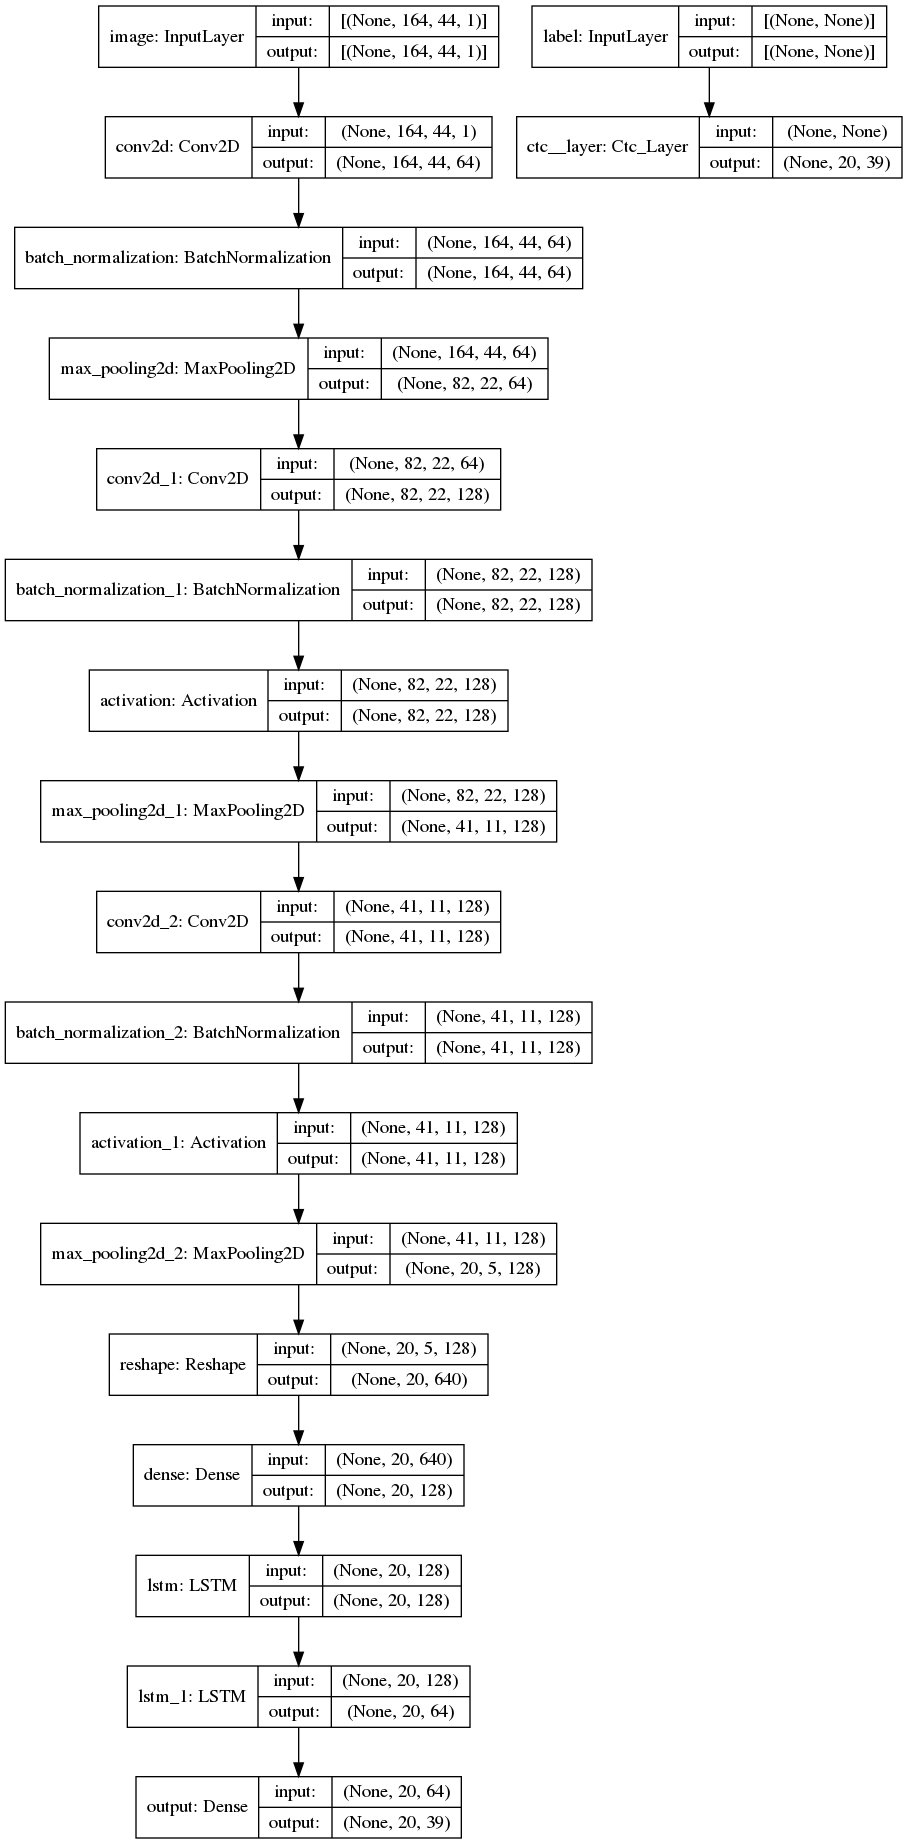

In [7]:
early_stop    = EarlyStopping(monitor="val_loss",patience=4,verbose=True)
tensor_board  = TensorBoard("OCR_logs/")
model_ckpt    = ModelCheckpoint("OCR_best_model.h5",save_best_only=True,save_weights_only=True)
callback_list = [early_stop,tensor_board,model_ckpt]
ocr_model = conv_rnn_ctc(img_width,img_height,max_length=max_length)
ocr_model.fit(train,validation_data=valid,steps_per_epoch=len(train_images)//batch_size,epochs=epochs,callbacks=callback_list)
tf.keras.utils.plot_model(ocr_model,"assets/model_plot.png",show_shapes=True)

#### Model Inference 

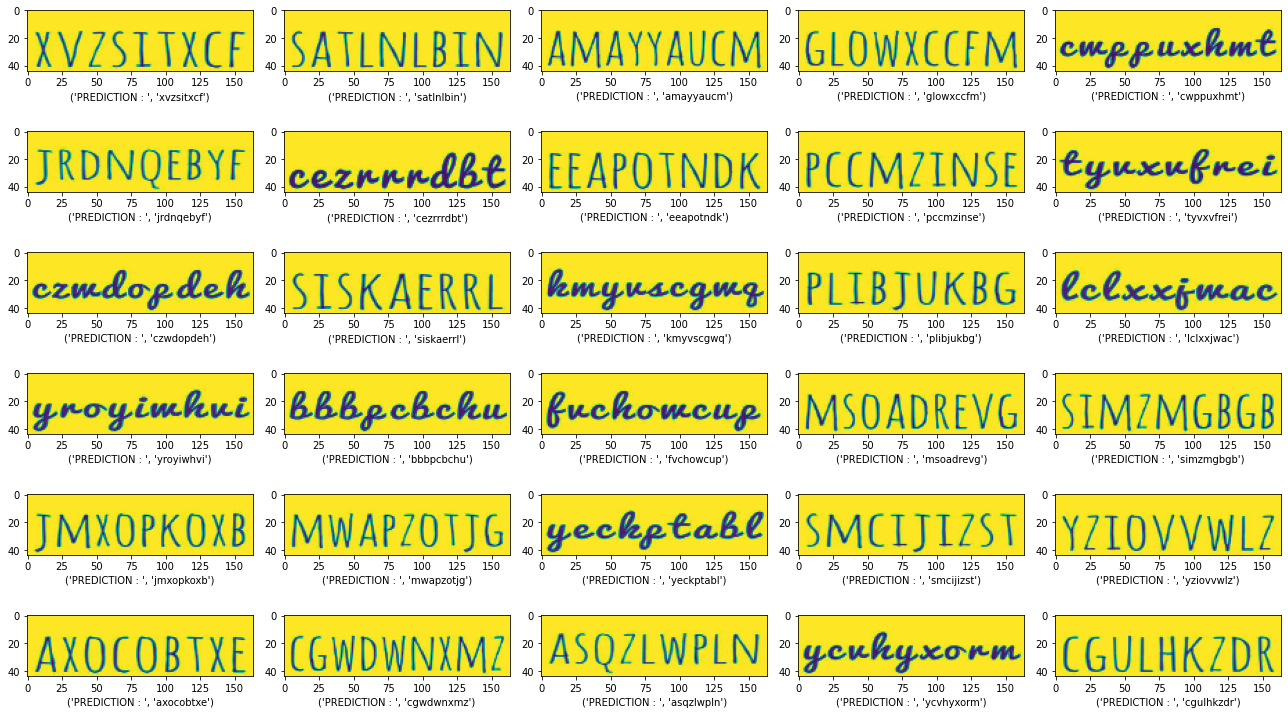

In [8]:
ocr_model.load_weights("OCR_best_model.h5")
predictor_net = Model(inputs=ocr_model.get_layer("image").input,outputs=ocr_model.get_layer("output").output)

start = 5
fig,ax = plt.subplots(6,5,figsize=(18,10))
ax = ax.flatten()
for i,files in enumerate(valid_images[start:start+30]):
    result,vis_image = predict(files,predictor=predictor_net,img_height=img_height,img_width=img_width,max_length=max_length)
    result = [i for i in result if i!=-1]
    words = [num2char[j] for j in result]
    words = "".join(words).replace("'","")
    words = "PREDICTION : ",words.replace(".","")
    ax[i].imshow(vis_image)
    ax[i].set_xlabel(words)
fig.tight_layout(h_pad=4)

### Training OCR model Caveats
* Choosing right image size and aspect ratio which doesn't distort text information.
  * How to avoid it?
    * Visualizing the dataset after preprocessing helps us to know the representation quality.
      ### Example of Distorted image:
      <p style="text-align:left"><img src="assets/error.png" alt="arch" width="190"/></p>
* Choosing right sequence lengths with respect to dataset for faster convergence.
* Choosing right image width or height based on the dataset characteristics.
* Choosing right parameters that refrains model from overfitting and divergence.